<a href="https://colab.research.google.com/github/tolism/House-Pricing-Core/blob/main/house_pricing_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000




In [111]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [113]:
string_attributes =[i for i in train.columns if train[i].dtypes =="object"]

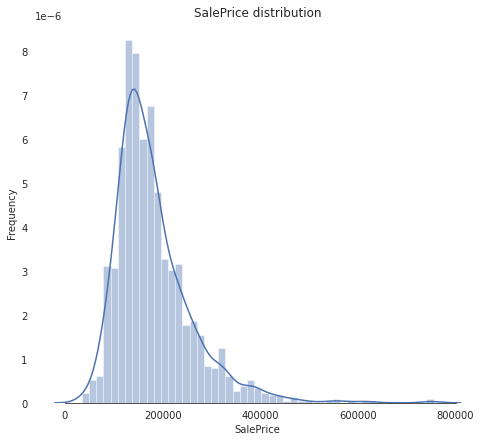

In [114]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [115]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


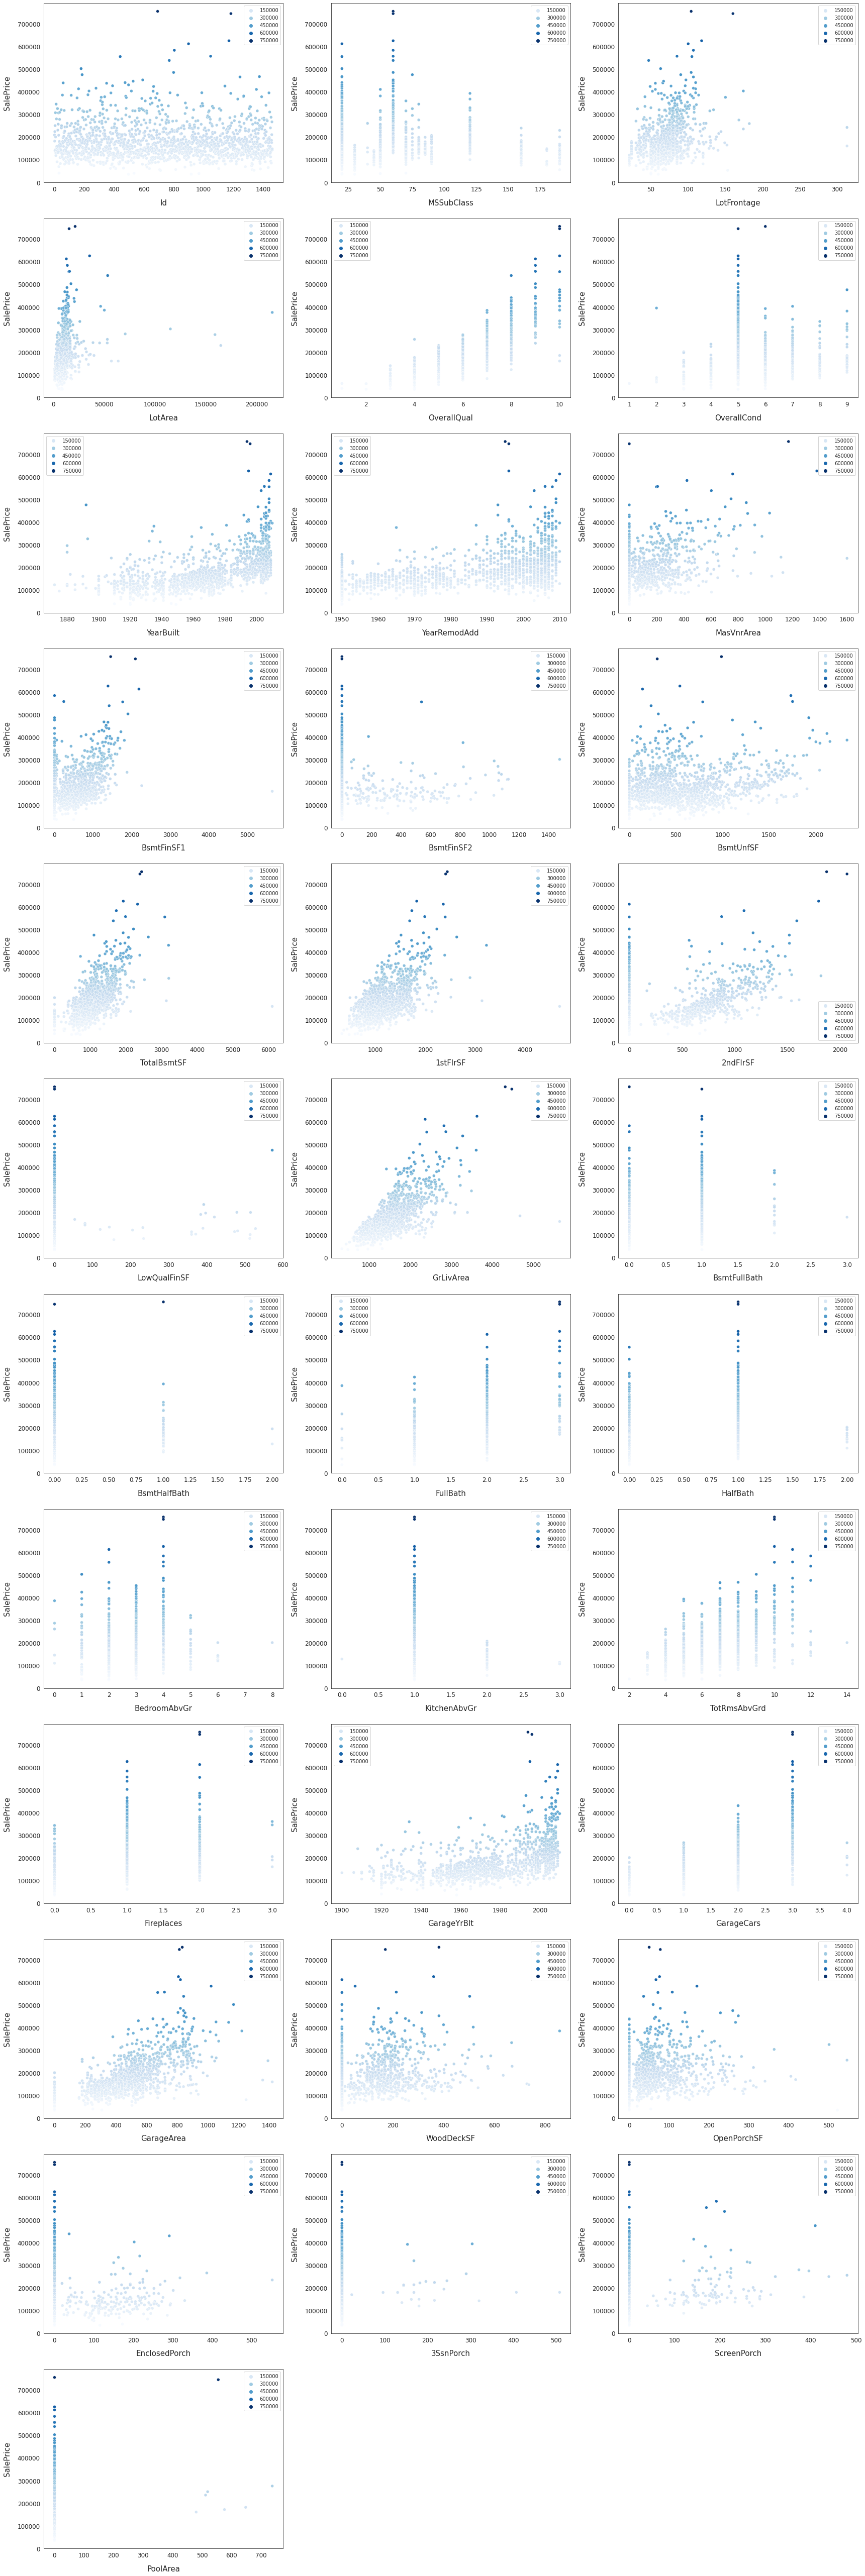

In [116]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
      numeric.append(i)  
        
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

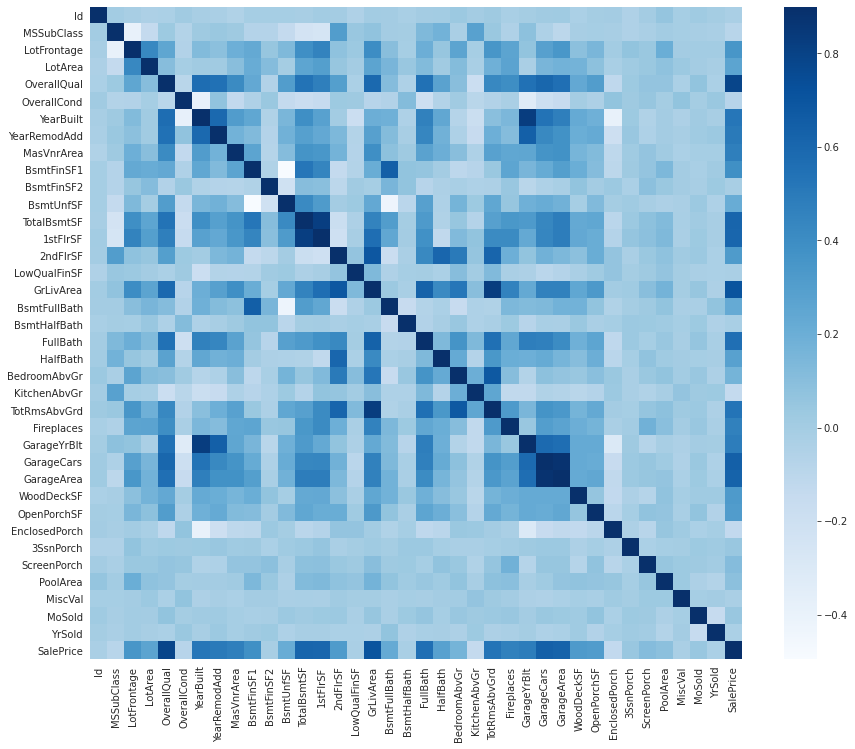

In [117]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

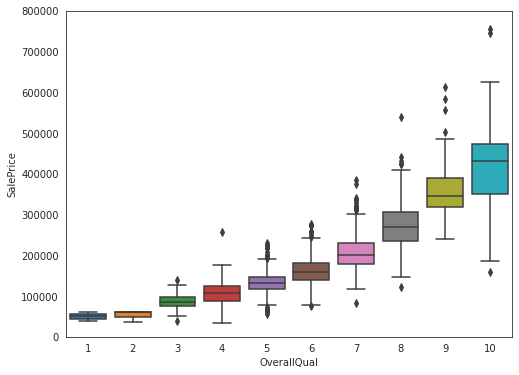

In [118]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

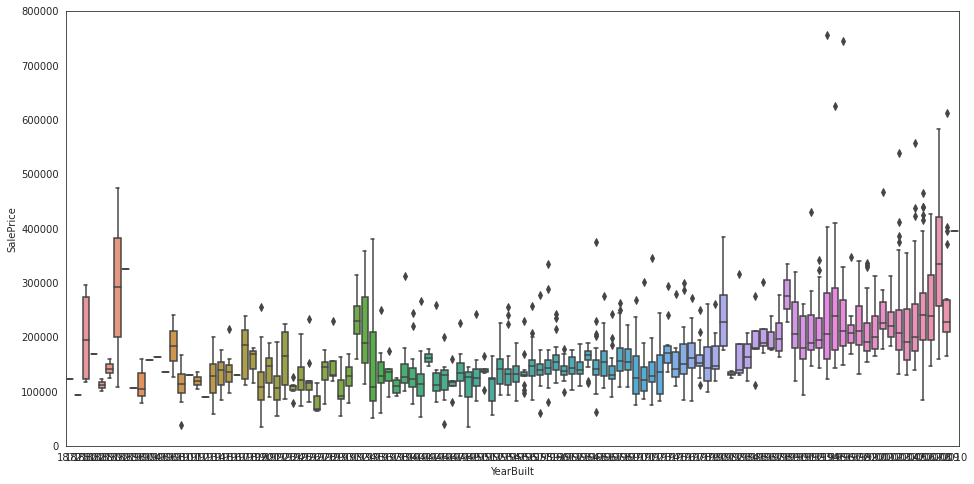

In [119]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


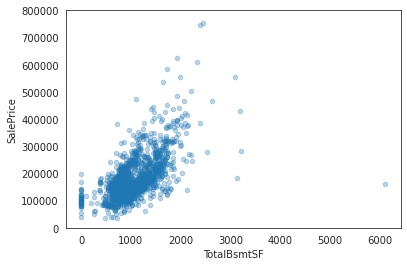

In [120]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

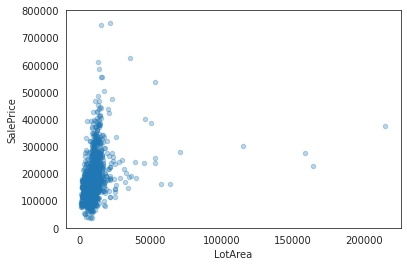

In [121]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

In [122]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

In [123]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True) 

In [124]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



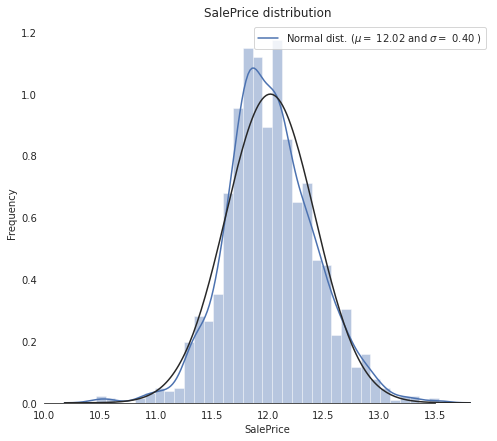

In [125]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [126]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [127]:
# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2916, 79)

In [128]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.42),
 ('FireplaceQu', 48.7),
 ('LotFrontage', 16.63),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

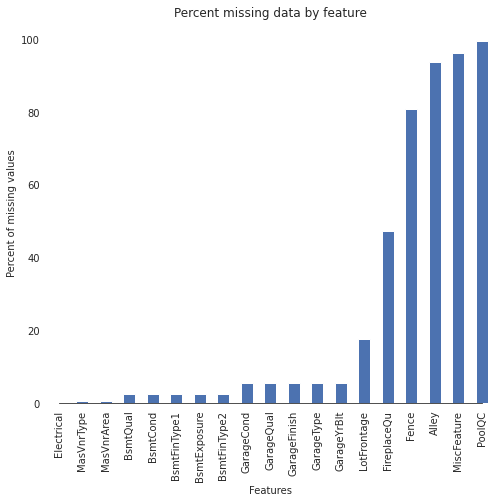

In [129]:
# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [130]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [131]:
#The mode of a set of values is the value that appears most often. It can be multiple values.
#We are going to use pandas.mode 

In [132]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [133]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [134]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

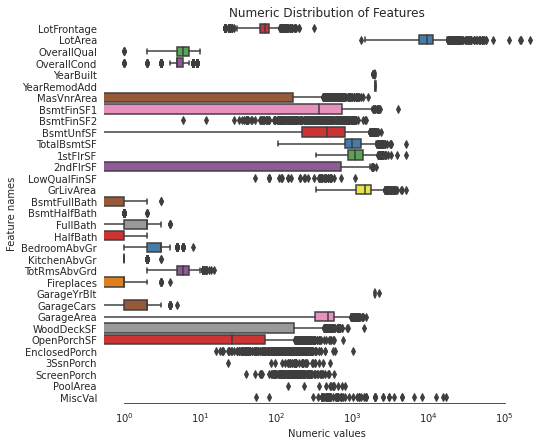

In [135]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [136]:
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

In [137]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

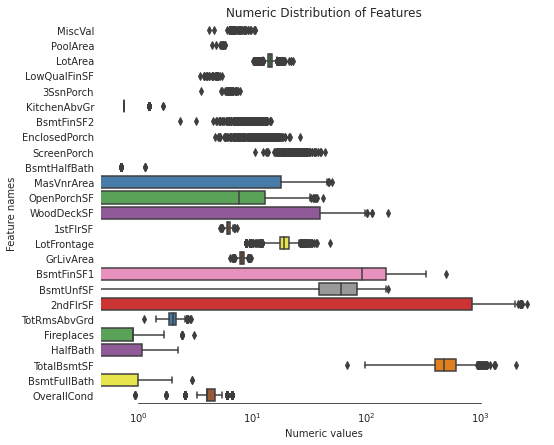

In [138]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [139]:
#ML models have trouble recognizing more complex patterns (and we're staying away from neural nets for this competition)
# so let's help our models out by creating a few features based on our intuition about the dataset
# e.g. total area of floors, bathrooms and porch area of each house.

In [140]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [141]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [142]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

In [143]:
pip install category_encoders

In [144]:
all_features = all_features.loc[:,~all_features.columns.duplicated()]

In [145]:
string_attributes =[i for i in all_features.columns if all_features[i].dtypes =="object"]

In [146]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1457, 132), (1457,), (1459, 132))

In [147]:
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtFinType1_Unf,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,YearsSinceRemodel,Total_Home_Quality,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,GrLivArea_log,BsmtFullBath_log,BsmtHalfBath_log,FullBath_log,HalfBath_log,BedroomAbvGr_log,KitchenAbvGr_log,TotRmsAbvGrd_log,Fireplaces_log,GarageCars_log,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq
1457,20,RH,20.660028,14.792628,None,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,4.677969,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,54.598150,TA,TA,CBlock,TA,TA,No,Rec,107.369500,LwQ,7.762051,42.845138,433.341697,GasA,TA,Y,SBrkr,5.964059,665.141633,0.0,7.540641,0.0,0.0,1,0.000000,2,0.750955,TA,1.835106,Typ,0.000000,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,34.329263,0.000000,0.0,0.0,19.081883,0.0,MnPrv,None,0.000000,6,2010,WD,Normal,0,0,1,1,1,0,49,9.677969,439.305756,3922,121.095611,1.000000,53.411146,0,1,1,1,0,3.075930,2.760176,4.018330,4.685639,2.171571,3.780892,6.073855,1.942197,6.501517,0.00995,2.146006,0.00995,0.00995,0.698135,0.009950,1.101940,0.565856,1.045600,0.009950,0.698135,6.594427,3.564995,0.009950,0.00995,0.00995,3.000316,0.00995,0.009950,7.581725,6.087492,3845521,9.461346,36.891709,3.772131,42.269727,4.605343,0.487392,43.486469
1458,20,RL,20.821246,15.279133,None,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,4.677969,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,14.646217,TA,TA,CBlock,TA,TA,No,ALQ,174.142394,Unf,0.000000,54.719064,620.860969,GasA,TA,Y,SBrkr,6.262998,665.141633,0.0,8.026316,0.0,0.0,1,1.068921,3,0.750955,Gd,1.997107,Typ,0.000000,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,67.061202,9.099536,0.0,0.0,0.000000,0.0,None,Gar2,10.246297,6,2010,WD,Normal,0,0,0,1,1,1,52,10.677969,627.123967,3916,180.405392,1.534461,76.160738,0,1,1,1,0,3.083342,2.790498,2.750868,5.165656,0.009950,4.020502,6.432733,1.984169,6.501517,0.00995,2.201252,0.00995,0.00995,0.698135,0.731849,1.388791,0.565856,1.100978,0.009950,0.698135,5.746235,4.220554,2.313479,0.00995,0.00995,0.009950,0.00995,2.420928,7.580195,6.442753,3833764,9.506999,41.380049,3.936925,42.269727,4.845508,0.487392,33.019218
1459,60,RL,19.674811,15.204735,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,3.990332,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,54.598150,TA,TA,PConc,Gd,TA,No,GLQ,156.044700,Unf,0.000000,28.393763,453.104929,GasA,Gd,Y,SBrkr,5.990851,837.268174,0.0,8.279373,0.0,0.0,2,1.068921,3,0.750955,TA,1.997107,Typ,0.903299,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,44.996868,8.819041,0.0,0.0,0.000000,0.0,MnPrv,None,0.000000,3,2010,WD,Normal,0,0,0,1,1,1,12,8.990332,1296.363954,3995,999.303725,2.534461,53.815910,0,1,1,1,1,3.029400,2.785920,4.018330,5.056594,0.009950,3.381123,6.118350,1.946032,6.731350,0.00995,2.228871,0.0

In [148]:
import category_encoders as ce
encoder = ce.JamesSteinEncoder(cols=string_attributes)
training_numeric_dataset = encoder.fit_transform(X, train_labels)
testing_numeric_dataset = encoder.transform(X_test)



**Key features of the model training process:¶**



*   Cross Validation: Using 12-fold cross-validation
*   Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
*   Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
*   Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.





In [151]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [152]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=training_numeric_dataset):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [154]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
#Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor.
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [181]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(training_numeric_dataset), np.array(train_labels))

stack_gen
[12:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [163]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(training_numeric_dataset, train_labels)

lightgbm


In [175]:
print('xgboost')
xgb_model_full_data = xgboost.fit(training_numeric_dataset, train_labels)

xgboost
[12:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [177]:
print('Svr')
svr_model_full_data = svr.fit(training_numeric_dataset, train_labels)

Svr


In [178]:
print('Ridge')
ridge_model_full_data = ridge.fit(training_numeric_dataset, train_labels)

Ridge


In [179]:
print('RandomForest')
rf_model_full_data = rf.fit(training_numeric_dataset, train_labels)

RandomForest


In [180]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(training_numeric_dataset, train_labels)

GradientBoosting


In [182]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [183]:
blended_score = rmsle(train_labels, blended_predictions(training_numeric_dataset))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07769325411758168


In [187]:
submission = pd.read_csv("sample_submission.csv")
submission.shape

(1459, 2)

In [188]:
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(testing_numeric_dataset)))

In [189]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [190]:
# Scale predictions
submission['SalePrice'] *= 1.001619
submission.to_csv("submission_regression2.csv", index=False)